# Подключение библиотек 

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from wordcloud import WordCloud, STOPWORDS

# Загрузка данных

In [2]:
# В данном случае параметр «./Data/train» указывает на имя папки, в которой будет находиться наша обучающая выборка 
reviews_train = load_files("./Data/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [3]:
# Загрузка тестовых данных 
reviews_test = load_files("./Data/test")
text_test, y_test = reviews_test.data, reviews_test.target

Для дальнейшей работы нам необходимо составить словарь уникальных слов, используемых в обучающей выборке. 
Для этого используется метод CountVectorizer

In [4]:
cv = CountVectorizer()
cv.fit(text_train)
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

cv = CountVectorizer()
cv.fit(text_test)
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']
['00', '000', '00000000000', '00000001', '000dm', '001', '0

In [6]:
x = np.array(y_train)
print(np.unique(x))
x = np.array(y_test)
print(np.unique(x))

[0 1]
[0 1]


Преобразование соварей текстов в векторную форму 

In [7]:
X_train = cv.transform(text_train)
X_test = cv.transform(text_test)

# Облако слов 

In [18]:
for i,j in zip(text_train, y_train):
    if j == 1:
        str_one_pos = " " + str(i) # формирование одной строки из списка комментариев 
    if j == 0:
        str_one_neg = " " + str(i)   

In [19]:
text_list = list(cv.vocabulary_.keys())
stopwords = set(STOPWORDS)
wordcloud1 = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(str_one_pos) 
wordcloud2 = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords, min_font_size = 10).generate(str_one_neg) 

(-0.5, 799.5, 799.5, -0.5)

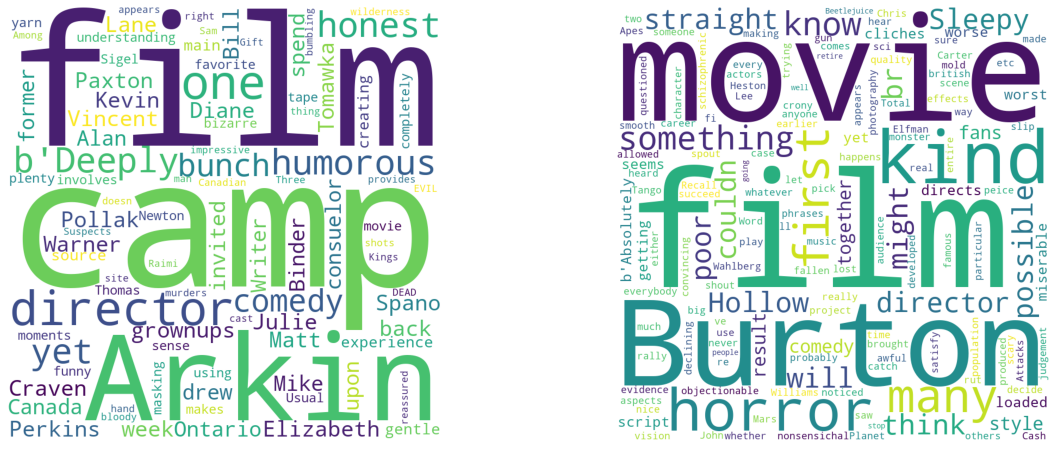

In [20]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.imshow(wordcloud1); ax1.axis("off")
ax2.imshow(wordcloud2); ax2.axis("off")

# Определение базовой модели

In [37]:
log_reg = LogisticRegression(solver='lbfgs', n_jobs=-5, random_state=10)
knei_class = KNeighborsClassifier(n_neighbors=10)
lin_svc=LinearSVC()
sgd_class = SGDClassifier(random_state=42)
rf_class = RandomForestClassifier()

In [38]:
log_reg.fit(X_train, y_train)
knei_class.fit(X_train, y_train)
lin_svc.fit(X_train, y_train)
sgd_class.fit(X_train, y_train)
rf_class.fit(X_train, y_train)

/home/una-user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/una-user/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


RandomForestClassifier()

In [39]:
predicted_knei = knei_class.predict(X_test)
predicted_rf = rf_class.predict(X_test)
predicted_sgd = sgd_class.predict(X_test)

#predicted_log = sgd_class.predict(X_test)


In [49]:
predicted_log = log_reg.predict(X_test)
predicted_log

array([1, 0, 1, ..., 0, 0, 0])

In [40]:
print(metrics.classification_report(predicted_knei, y_test))

              precision    recall  f1-score   support

           0       0.63      0.64      0.64     12296
           1       0.65      0.64      0.64     12704

    accuracy                           0.64     25000
   macro avg       0.64      0.64      0.64     25000
weighted avg       0.64      0.64      0.64     25000



In [41]:
print(metrics.classification_report(predicted_rf, y_test))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84     12534
           1       0.84      0.85      0.84     12466

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



print(metrics.classification_report(predicted_sgd, y_test))

print(round(log_reg.score(X_train, y_train),3), round(log_reg.score(X_test, y_test),3))